# Richardson-Lucy Deconvolution

In this notebook, we try to implement the easiest and most flexible deconvolution approach to enhance resolution in blurred images: the Richardson-Lucy deconvolution method.

First, we import appropriate libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import filters

from scipy import signal

We need to load a default image to play with. We take a few image examples provided by the skimage library.

In [3]:
# we load a standard image
camera = data.shepp_logan_phantom()
camera = data.camera()

# intensity normalization
camera = np.float32(camera[1:,1:])
camera /= camera.max()

Successively, we need to define a PSF that will blur the image.
First, we dicide how big is the kernel that we want (better an odd number of pixels), we locate the center and we set 1 in there. This corresponds to an ideal delta response of the system. 

Then, we blur the response of the system with a Gaussian filter. We do this for simplicity, but you could have done the same by defining a 2D Gaussian function with a centered maximum and obtain the same results.

In [4]:
# kernel size and properties
kernelsize = camera.shape[0]
center = np.uint32(np.floor(kernelsize/2.))

# ideal system response
delta = np.zeros([kernelsize,kernelsize])
delta[center,center] = 1

# Gaussian optical response
psf = filters.gaussian(delta, sigma=2)

Then, we blur the image. 

This time we use the function signal.convolve from scipy library. 
The function, accordingly with the size of the psf that we use, decides which method is faster to carry out the convolution between FFT, direct products and overlap-add methods.

It implements:
$$ I = O * K $$

In [5]:
# blurring the signal
camera_blurred = signal.convolve(camera, psf, 'same')

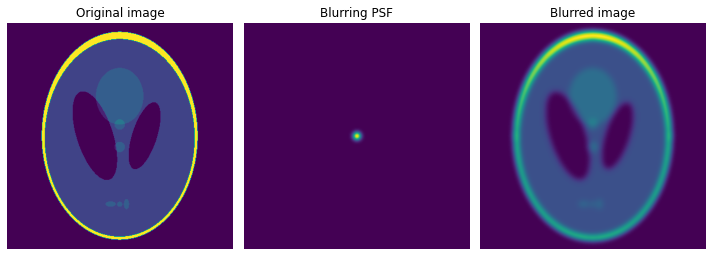

In [6]:
plt.figure(figsize=[10,10])
plt.subplot(131), plt.imshow(camera), plt.axis('off'), plt.title('Original image')
plt.subplot(132), plt.imshow(psf), plt.axis('off'), plt.title('Blurring PSF')
plt.subplot(133), plt.imshow(camera_blurred), plt.axis('off'), plt.title('Blurred image')
plt.tight_layout()

Now that we have blurred the image, we write the function to deconvolve with the RL iterative method. We also write a function that monitor the a-posteriori distance.

The distance is defined as:
$$ d= \sum_{x,y} \left\| I - O*K \right\|^2  $$

and the RL deconvolution is:
$$ O_{t+1} = O_t \cdot \left( \frac{I}{O_t*K} * \tilde{K}  \right)  $$


In [7]:
def euclideandistance(image1, image2):
    distance = ((image1-image2)**2).sum()
    
    return distance


def deconvolutionRL(blurred, psf, iterations=10):
    # reconstruction initialization as the blurred item
    deconvolved = blurred.copy()
    deconvolved = np.ones_like(blurred)/(blurred.shape[0]**2)
    distance = np.zeros([iterations,])
    
    for i in range(iterations): 
        # useful quantities
        forwardblur = signal.convolve(deconvolved, psf, 'same')
        ratio = blurred / forwardblur
        #deconvolved = np.maximum(ratio, 1e-6, dtype = 'float32')

        distance[i] = euclideandistance(blurred, forwardblur)
        
        # iterative update
        deconvolved *= signal.correlate(ratio, psf, 'same') 

    return deconvolved, distance

And we use it...

In [8]:
# running the deconvolution
camera_deconvolved, distance = deconvolutionRL(camera_blurred, psf, iterations=1000)

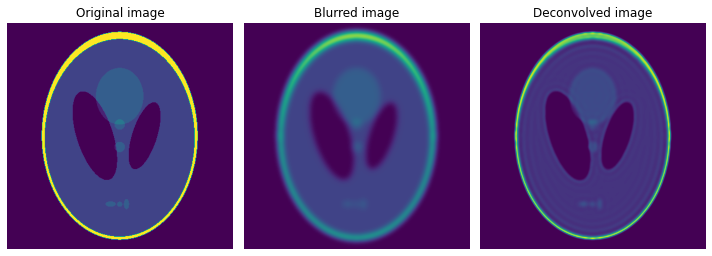

In [9]:
plt.figure(figsize=[10,10])
plt.subplot(131), 
plt.imshow(camera, vmin=0, vmax=1), 
plt.axis('off'), 
plt.title('Original image')

plt.subplot(132), 
plt.imshow(camera_blurred, vmin=0, vmax=1),
plt.axis('off'),
plt.title('Blurred image')

plt.subplot(133),
plt.imshow(camera_deconvolved),
plt.axis('off'),
plt.title('Deconvolved image')
plt.tight_layout()

We plot also the profiles to compare edges and explicitly evaluate the deconvolution effect.

Text(0, 0.5, 'Euclidean distance')

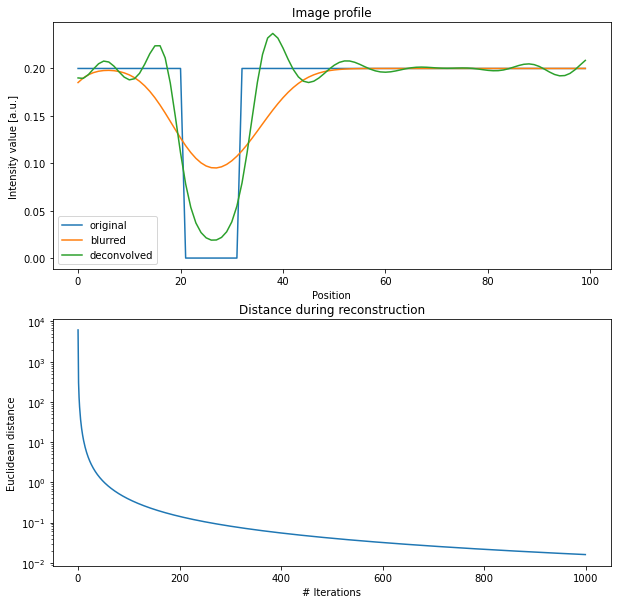

In [10]:
profile = 256
plt.figure(figsize=[10,10])

plt.subplot(211)
plt.plot(camera[profile,200:300])
plt.plot(camera_blurred[profile,200:300])
plt.plot(camera_deconvolved[profile,200:300])
plt.legend(['original', 'blurred', 'deconvolved'])
plt.title('Image profile')
plt.xlabel('Position')
plt.ylabel('Intensity value [a.u.]')

plt.subplot(212)
plt.plot(distance)
plt.yscale('log')
plt.title('Distance during reconstruction')
plt.xlabel('# Iterations')
plt.ylabel('Euclidean distance')

It is useful to explicitly see what happens in the Fourier domain, since blurring is all about loosing information at high-frequencies.

To evaluate this, we compare the Fourier modulus of the original, blurred and deconvolved images.
We see that the original image has a full spectrum of frequencies, whereas the blurred version has a much attenuated version of it, progressively fading outside the central (low-frequency) core.

It appears clear what the deconvolution is doing: is recovering the Fourier information at the high-frequency regime, where all the details are stored.

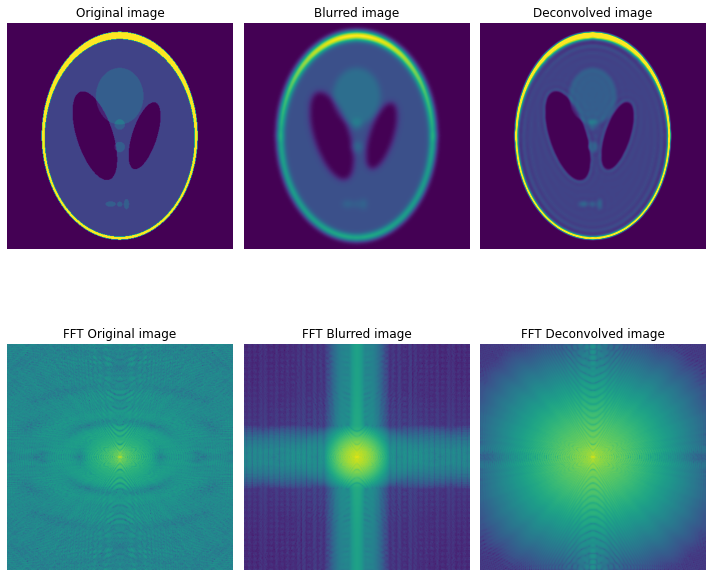

In [11]:
plt.figure(figsize=[10,10])
plt.subplot(231), plt.imshow(camera, vmin=0, vmax=1), plt.axis('off'), plt.title('Original image')
plt.subplot(232), plt.imshow(camera_blurred), plt.axis('off'), plt.title('Blurred image')
plt.subplot(233), plt.imshow(camera_deconvolved, vmin=0, vmax=1), plt.axis('off'), plt.title('Deconvolved image')

camera_fft_abs = np.abs(np.fft.fftshift(np.fft.fft2(camera)))
camera_blurred_fft_abs = np.abs(np.fft.fftshift(np.fft.fft2(camera_blurred)))
camera_deconvolved_fft_abs = np.abs(np.fft.fftshift(np.fft.fft2(camera_deconvolved)))

plt.subplot(234), plt.imshow(np.log(camera_fft_abs)), plt.axis('off'), plt.title('FFT Original image')
plt.subplot(235), plt.imshow(np.log(camera_blurred_fft_abs)), plt.axis('off'), plt.title('FFT Blurred image')
plt.subplot(236), plt.imshow(np.log(camera_deconvolved_fft_abs)), plt.axis('off'), plt.title('FFT Deconvolved image')

plt.tight_layout()

# The presence of noise

Everything was working smoothly so far, but in this case also the spectral deconvolution would have worked.

To see what's better about the RL, we add the noise. We recall that with $\alpha>10^{11} $ the spectral division fails.

It implements:
$$ I = O * K + \varepsilon $$

In [12]:
# blurring the signal
noise = np.random.rand(camera.shape[0], camera.shape[1])
alpha = 0.1

camera_blurred = signal.convolve(camera, psf, 'same') + alpha * noise

And now we run the deconvolution on the noisy and blurred image!

In [13]:
# running the deconvolution
camera_deconvolved, distance = deconvolutionRL(camera_blurred, psf, iterations=100)

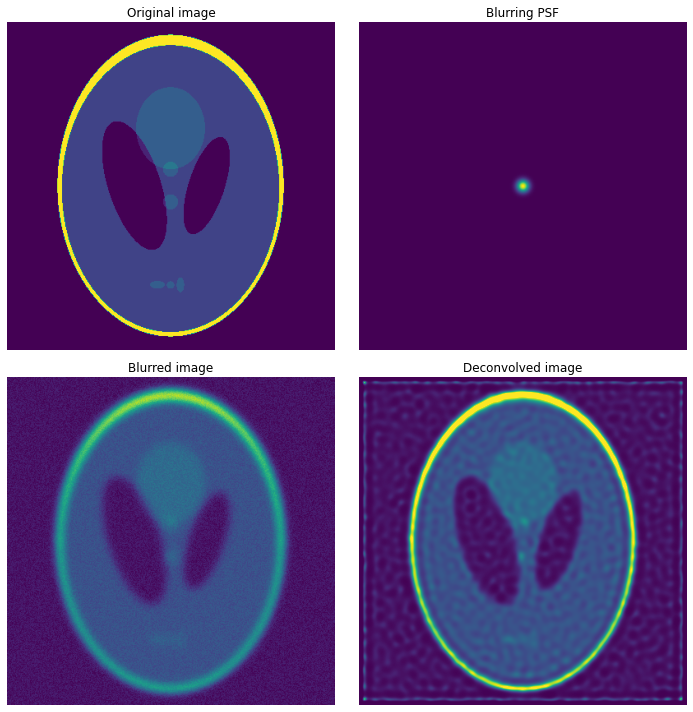

In [14]:
plt.figure(figsize=[10,10])
plt.subplot(221), 
plt.imshow(camera, vmin=0, vmax=1), 
plt.axis('off'), 
plt.title('Original image')

plt.subplot(222), 
plt.imshow(psf), 
plt.axis('off'), 
plt.title('Blurring PSF')

plt.subplot(223), 
plt.imshow(camera_blurred, vmin=0, vmax=1),
plt.axis('off'),
plt.title('Blurred image')

plt.subplot(224),
plt.imshow(camera_deconvolved, vmin=0, vmax=1),
plt.axis('off'),
plt.title('Deconvolved image')
plt.tight_layout()

It is not a trivial result, since now the noise can be almost 10 orders of magnitude higher than before!!! 
More importantly, the algorithm continously behave as a function of the noise, not presenting a critical regime at which suddently fails.

Here, we plot profiles and convergence trend.

Text(0, 0.5, 'Euclidean distance')

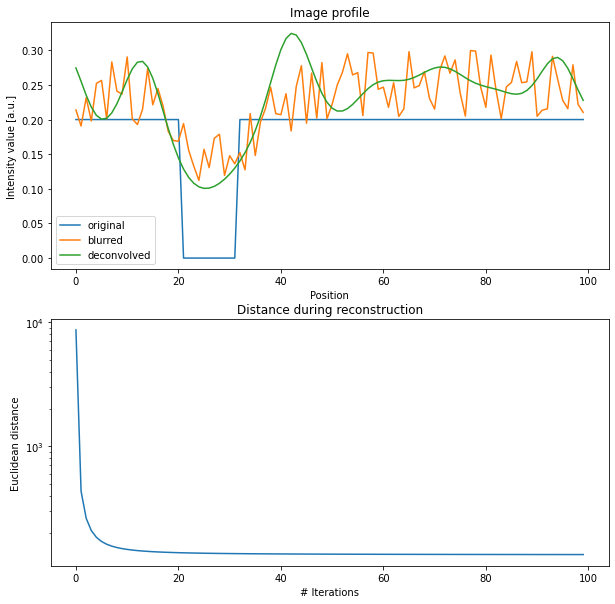

In [15]:
profile = 256
plt.figure(figsize=[10,10])

plt.subplot(211)
plt.plot(camera[profile,200:300])
plt.plot(camera_blurred[profile,200:300])
plt.plot(camera_deconvolved[profile,200:300])
plt.legend(['original', 'blurred', 'deconvolved'])
plt.title('Image profile')
plt.xlabel('Position')
plt.ylabel('Intensity value [a.u.]')

plt.subplot(212)
plt.plot(distance)
plt.yscale('log')
plt.title('Distance during reconstruction')
plt.xlabel('# Iterations')
plt.ylabel('Euclidean distance')

To understand what happens at different noise regimes, we could run several reconstructions with different noise levels. 
We notice that increasing the noise level reduce the accuracy of the reconstruction (the measured euclidean distance increases) and does not improve considerably increasing the number of iterations. 

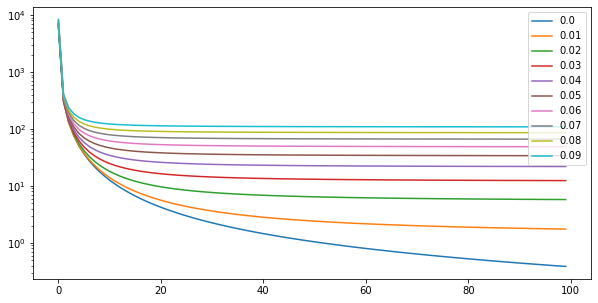

In [16]:
# error study
plt.figure(figsize=[10,5])
for i in range(10):
    noise = np.random.rand(camera.shape[0], camera.shape[1])
    alpha = i * 0.01
    camera_blurred = signal.convolve(camera, psf, 'same') + alpha * noise
    camera_deconvolved, distance = deconvolutionRL(camera_blurred, psf, iterations=100)
    #distance /= distance.max()
    plt.plot(distance)
    
plt.legend([ x*0.01 for x in range(10) ])
plt.yscale('log')